# Look back XGBoost stock prediction

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


In [3]:
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(1592, 1) (397, 1)


In [4]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [6]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train.shape,y_train.shape


(torch.Size([1542, 50, 1]), torch.Size([1542, 1]))

In [7]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
	X_test.append(scaled_test[i:i+sequence_length])
	y_test.append(scaled_test[i+sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32).float().squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32).float()
X_test.shape,y_test.shape


(torch.Size([347, 50]), torch.Size([347, 1]))

## Modelling

[0]	train-rmse:0.16808	eval-rmse:0.20754


/Users/baga_nuhkadiev/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:47:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-rmse:0.11882	eval-rmse:0.15453
[2]	train-rmse:0.08417	eval-rmse:0.11936
[3]	train-rmse:0.05986	eval-rmse:0.09898
[4]	train-rmse:0.04285	eval-rmse:0.08632
[5]	train-rmse:0.03101	eval-rmse:0.08142
[6]	train-rmse:0.02280	eval-rmse:0.07799
[7]	train-rmse:0.01715	eval-rmse:0.07705
[8]	train-rmse:0.01332	eval-rmse:0.07623
[9]	train-rmse:0.01069	eval-rmse:0.07595
[10]	train-rmse:0.00896	eval-rmse:0.07520
[11]	train-rmse:0.00781	eval-rmse:0.07493
[12]	train-rmse:0.00703	eval-rmse:0.07511
[13]	train-rmse:0.00651	eval-rmse:0.07499
[14]	train-rmse:0.00618	eval-rmse:0.07504
[15]	train-rmse:0.00587	eval-rmse:0.07503
[16]	train-rmse:0.00563	eval-rmse:0.07487
[17]	train-rmse:0.00545	eval-rmse:0.07500
[18]	train-rmse:0.00529	eval-rmse:0.07504
[19]	train-rmse:0.00514	eval-rmse:0.07496
[20]	train-rmse:0.00507	eval-rmse:0.07494
[21]	train-rmse:0.00495	eval-rmse:0.07513
[22]	train-rmse:0.00477	eval-rmse:0.07507
[23]	train-rmse:0.00472	eval-rmse:0.07508
[24]	train-rmse:0.00463	eval-rmse:0.07515
[

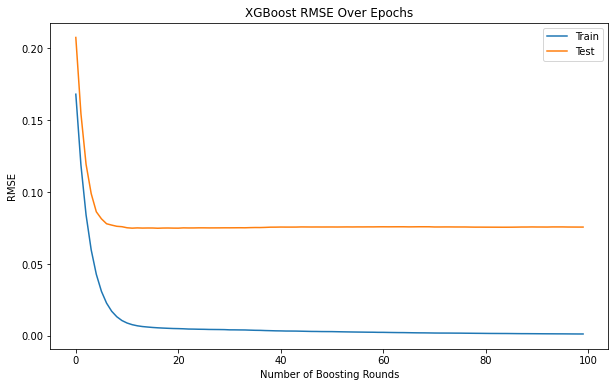

[0.8846311  0.87884897 0.8421826  0.897595   0.91101253 0.9291929
 0.9368604  0.9571933  0.9334872  0.93323565]
RMSE: 0.07568258792161942


In [13]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train.squeeze(), label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'n_estimators': 1000
}

# Train the model and capture evaluation results
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dtest, 'eval')],
                  evals_result=evals_result, verbose_eval=True)

# Plot the training and evaluation loss
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['eval']['rmse'], label='Test')
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs')
plt.show()

# Make predictions on the test set
predictions = model.predict(dtest)

# Print out a few predictions
print(predictions[:10])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")


In [14]:
predictions = model.predict(dtest)
with torch.no_grad():
    t = scaler.inverse_transform(y_test)
    tp = scaler.inverse_transform(predictions.reshape(-1, 1))
math.sqrt(mean_squared_error(t, tp))    

200.72622392063684

In [15]:
with torch.no_grad():
    tpreds = model.predict(dtrain)
    tr = scaler.inverse_transform(y_train)
    trp = scaler.inverse_transform(tpreds.reshape(-1, 1))
    print(math.sqrt(mean_squared_error(tr, trp)))


3.5651056463384108


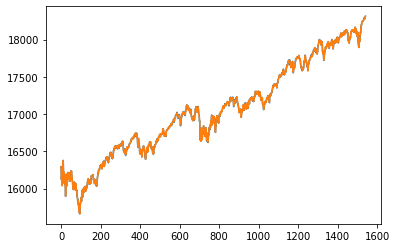

In [16]:
import matplotlib.pyplot as plt

plt.plot(tr)
plt.plot(trp)

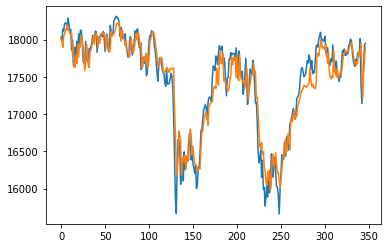

In [17]:
plt.plot(t)
plt.plot(tp)
